In [8]:
import sys
import cv2
sys.path.append('../../')
from retinal_dataset.datasets_setup import get_train_val_dataset
from nntools.utils import Config
import pandas as pd
import tqdm
import numpy as np

%load_ext autoreload
%autoreload 2
from bokeh.layouts import column, row
from script import plot_violin
from bokeh.io import output_notebook, show, save, output_file



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
config = Config('../../config_idrid_messidor_fgadr.yaml')

img_idrid_root = config['Dataset']['img_idrid_url']
mask_idrid_root = config['Dataset']['mask_idrid_url']

img_messidor_root = config['Dataset']['img_messidor_url']
mask_messidor_root = config['Dataset']['mask_messidor_url']

img_fgadr_root = config['Dataset']['img_fgadr_url']
mask_fgadr_root = config['Dataset']['mask_fgadr_url']

d_idrid = get_train_val_dataset(roots_idrid=(img_idrid_root, mask_idrid_root),
                                  shape=config['Dataset']['shape'],
                                  ratio_validation=0)['train'][0]


d_messidor = get_train_val_dataset(roots_messidor=(img_messidor_root, mask_messidor_root),
                                    roots_idrid=(img_idrid_root, mask_idrid_root),
                                  shape=config['Dataset']['shape'],
                                  ratio_validation=0)['train'][1]

d_fgadr = get_train_val_dataset(roots_fgadr=(img_fgadr_root, mask_fgadr_root),
                                roots_idrid=(img_idrid_root, mask_idrid_root),
                                  shape=config['Dataset']['shape'],
                                  ratio_validation=0)['train'][1]

img_root = config['Test']['img_url']
mask_root = config['Test']['mask_url']
img_retles_root = config['Test']['img_retles_url']
mask_retles_root = config['Test']['mask_retles_url']

d_retles = get_train_val_dataset(roots_idrid=(img_root, mask_root),
                          root_retlesion=(img_retles_root, mask_retles_root),
                          shape=config['Dataset']['shape'],
                          ratio_validation=0)['train'][1]

/store/usagers/clpla/NNTools/nntools/tracker/logger.py:11: UserWarning: Mismatch between the size of the different input folders (longer 54, smaller 26)
  warnings.warn(msg, UserWarning)
/store/usagers/clpla/NNTools/nntools/tracker/logger.py:11: UserWarning: Upsampling missing labels to fit the dataset's size (54)
  warnings.warn(msg, UserWarning)
/store/usagers/clpla/NNTools/nntools/tracker/logger.py:11: UserWarning: Mismatch between the size of the different input folders (longer 27, smaller 14)
  warnings.warn(msg, UserWarning)
/store/usagers/clpla/NNTools/nntools/tracker/logger.py:11: UserWarning: Upsampling missing labels to fit the dataset's size (27)
  warnings.warn(msg, UserWarning)
/store/usagers/clpla/NNTools/nntools/tracker/logger.py:11: UserWarning: Mismatch between the size of the different input folders (longer 1593, smaller 471)
  warnings.warn(msg, UserWarning)
/store/usagers/clpla/NNTools/nntools/tracker/logger.py:11: UserWarning: Upsampling missing labels to fit the d

In [4]:
labels = ['Cotton_Wool_Spot', 'Exudates', 'Hemorrhages', 'Microaneurysms']

def compute_stats_per_image(dataset):
    connectivity = 4  
    stats = {l+'_%s'%attribute+'_%s'%stat:[] for l in labels for attribute in ['size'] for stat in ['mean', 'std']}
    stats.update({l+'_%s'%attribute:[] for l in labels for attribute in ['number']})
    for batch in tqdm.tqdm(dataset):
        mask = batch['mask'].numpy()
        for c, label in zip(mask, labels):
            output = cv2.connectedComponentsWithStats(c.astype(np.uint8), connectivity, cv2.CV_32S)
            num_labels = output[0]
            stats[label+'_number'].append(num_labels-1)
            stats_matrix = output[2]
            stats[label+'_size_mean'].append(np.mean(stats_matrix[1:, cv2.CC_STAT_AREA]))
            stats[label+'_size_std'].append(np.std(stats_matrix[1:, cv2.CC_STAT_AREA]))
    return stats

def compute_stats_per_global(dataset):
    connectivity = 4  
    stats = {l+'_%s'%attribute+'_%s'%stat:[] for l in labels for attribute in ['size'] for stat in ['mean', 'std']}
    stats.update({l+'_%s'%attribute:[] for l in labels for attribute in ['number']})
    for batch in tqdm.tqdm(dataset):
        mask = batch['mask'].numpy()
        for c, label in zip(mask, labels):
            output = cv2.connectedComponentsWithStats(c.astype(np.uint8), connectivity, cv2.CV_32S)
            num_labels = output[0]
            stats[label+'_number'].append(num_labels-1)
            stats_matrix = output[2]
            stats[label+'_sizes'].append((stats_matrix[1:, cv2.CC_STAT_AREA]))
    return stats

# stats_idrid = compute_stats(d_idrid)
# stats_messidor = compute_stats(d_messidor)
# stats_fgadr = compute_stats(d_fgadr)
# stats_retles = compute_stats(d_retles)

In [9]:
stats_idrid = pd.read_pickle('idrid.pkl')
stats_messidor = pd.read_pickle('messidor.pkl')
stats_fgadr = pd.read_pickle('fgadr.pkl')
stats_retles = pd.read_pickle('retles.pkl')
stats_idrid['dataset'] = 'IDRID'
stats_messidor['dataset'] = 'MESSIDOR'
stats_fgadr['dataset'] = 'FGADR'
stats_retles['dataset'] = 'Retinal-Lesions'

b_labels = ['Cotton_Wool_Spot', 'Exudates']
r_labels = ['Hemorrhages', 'Microaneurysms']
df = pd.concat([stats_idrid, stats_messidor, stats_fgadr, stats_retles])

measure_b = ['Average bright lesions size (per image)', "Number of bright lesions (per image)"]
measure_r = ['Average red lesions size (per image)', "Number of red lesions (per image)"]

df[measure_b[1]] = sum([df[l+'_number'] for l in b_labels])
df[measure_b[0]] = sum([df[l+'_size_mean'] for l in b_labels])/len(b_labels)

df[measure_r[1]] = sum([df[l+'_number'] for l in r_labels])
df[measure_r[0]] = sum([df[l+'_size_mean'] for l in r_labels])/len(r_labels)

categories = df['dataset'].unique()
for m in measure_b+measure_r:
    df = df[df[m]>0]
    for c in categories:
        df.loc[df.dataset==c, m] = 100*df[df.dataset==c][m]/df[m].max()

In [60]:
output_notebook()
output_file("distribution_lesions_bright_red.html")
p1 = plot_violin(df, 'dataset', measure_b, scales=(1, -8),  x_range=(-5,50), title="Bright Lesions", plot_size=(1000,400))
p2 = plot_violin(df, 'dataset', measure_r, scales=(1, -8), x_range=(-5,50), title="Red Lesions", plot_size=(1000,400))
# show(row(p1, p2))

save(column(p1, p2))

Loading BokehJS ...

'/store/usagers/clpla/Projects/FundusSegmentation/notebooks/datasets/distribution_lesions_bright_red.html'

In [11]:
import sys
sys.path.append('../../')
from constants import *
source = {'Dataset':['IDRID', 'MESSIDOR', 'Retinal-Lesions', 'FGADR'], 
          'Number of images':["54+27", "200", "1593", "1842"], 
          'Image resolution':["2848x4288", "1500x1500", "896x896", "1280x1280"],
          'Classes':[', '.join(IDRID_labels).replace('_', ' '), 
                     ', '.join(Messidor_labels).replace('_', ' '), 
                     ', '.join(RetLes_labels).replace('_', ' '), 
                     ', '.join(FGADR_labels).replace('_', ' ')]} 

df_dataset = pd.DataFrame(source)
df_dataset.set_index('Dataset', inplace=True)
html = df_dataset.to_html(justify='center')
with open("dataset_description.html", 'w') as file:
    file.write(html)
    
df_dataset

,Number of images,Image resolution,Classes
Dataset,,,
IDRID,54+27,2848x4288,"Retina, Cotton Wool Spot, Exudates, Hemorrhage..."
MESSIDOR,200,1500x1500,"Non ROI, Vessels, Optic disk, Optic cup, Macul..."
Retinal-Lesions,1593,896x896,"Retina, Cotton Wool Spot, Exudates, Hemorrhage..."
FGADR,1842,1280x1280,"Retina, Cotton Wool Spot, Exudates, Hemorrhage..."


41
9
33


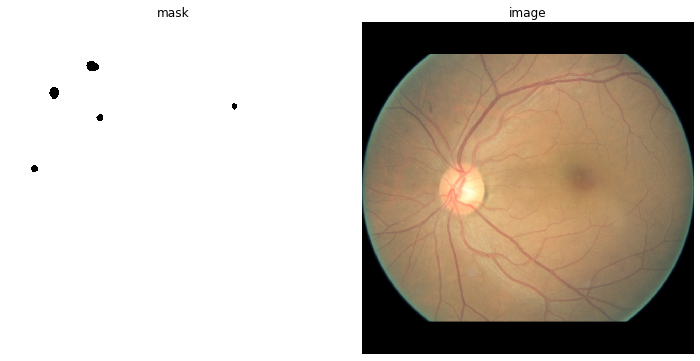

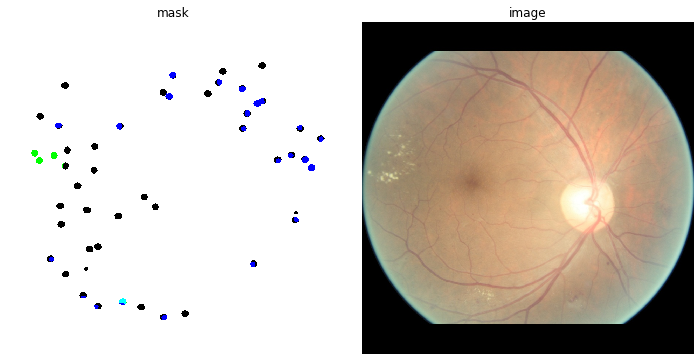

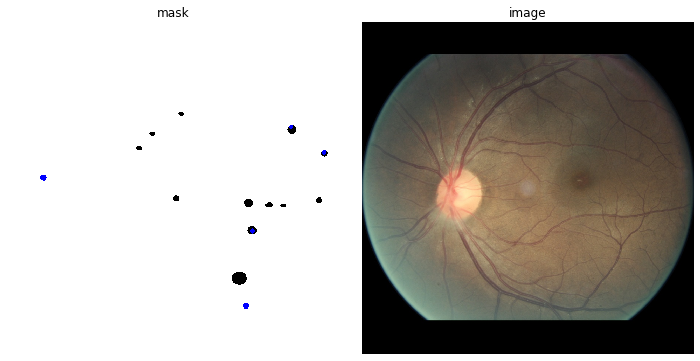

In [58]:
d_messidor = get_train_val_dataset(roots_messidor=(img_messidor_root, mask_messidor_root),
                                  shape=[1280,1280],
                                  ratio_validation=0)['train'][0]

d_fgadr = get_train_val_dataset(roots_fgadr=(img_fgadr_root, mask_fgadr_root),
                                  shape=[1280,1280],
                                  ratio_validation=0)['train'][0]

d_retles = get_train_val_dataset(root_retlesion=(img_retles_root, mask_retles_root),
                          shape=[1280,1280],
                          ratio_validation=0)['train'][0]


d_idrid = get_train_val_dataset(roots_idrid=(img_idrid_root, mask_idrid_root),
                                  shape=config['Dataset']['shape'],
                                  ratio_validation=0)['train'][0]


d = d_retles
index = np.random.randint(0,54,3)
for i in index:
    print(i)
    d.plot(i)

In [59]:
from script import mix_img_and_mask
batch = d[9]
img = batch['image'].numpy().transpose(1,2,0)
mask = batch['mask'].numpy()
mask_b = mask[0]+mask[1]
mask_r = mask[2]+mask[3]

out=mix_img_and_mask(img.astype(np.uint8), [mask_r, mask_b])
cv2.imwrite('RetLes_example.png', out[:,:,::-1])

True

In [ ]:
out.max()